In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_frame = pd.read_csv('./mnist_train.csv', delimiter=',')
data_frame.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data_with_7 = data_frame.loc[data_frame['label'] == 7]
data_without_7 = data_frame.loc[data_frame['label'] != 7]

print(data_frame.shape)
print(data_with_7.shape)
print(data_without_7.shape)

(60000, 785)
(6265, 785)
(53735, 785)


In [4]:
train_data = data_without_7.to_numpy()
test_data = data_with_7.to_numpy()

train_labels = train_data[:, 0]
test_labels = test_data[:, 0]

train_data = train_data[:, 1:]
test_data = test_data[:, 1:]

print(train_labels.shape)
print(test_labels.shape)
print(train_data.shape)
print(test_data.shape)

(53735,)
(6265,)
(53735, 784)
(6265, 784)


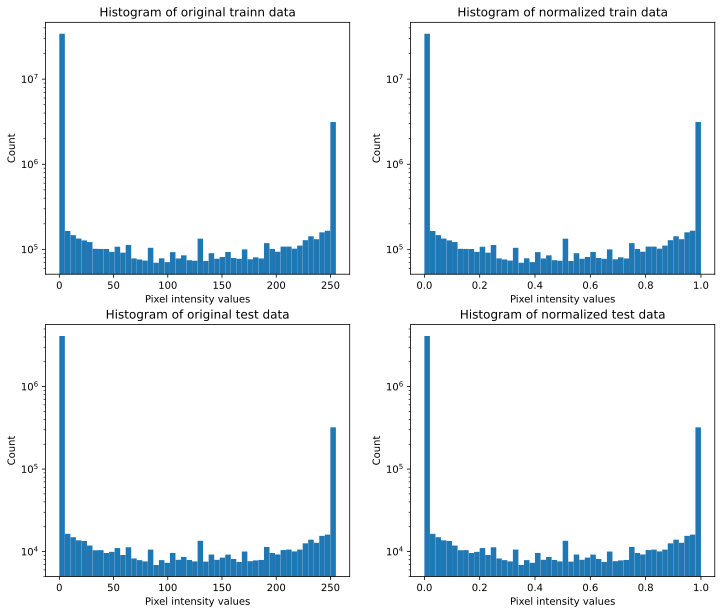

In [5]:
# normalize data to a range of [0, 1]
train_data_norm = train_data / np.max(train_data)
test_data_norm = test_data / np.max(test_data)


fig, ax = plt.subplots(2,2,figsize=(12,10))
ax[0, 0].hist(train_data.flatten(), 50)
ax[0, 0].set_xlabel('Pixel intensity values')
ax[0, 0].set_ylabel('Count')
ax[0, 0].set_title('Histogram of original trainn data')
ax[0, 0].set_yscale('log')

ax[0, 1].hist(train_data_norm.flatten(), 50)
ax[0, 1].set_xlabel('Pixel intensity values')
ax[0, 1].set_ylabel('Count')
ax[0, 1].set_title('Histogram of normalized train data')
ax[0, 1].set_yscale('log')

ax[1, 0].hist(test_data.flatten(), 50)
ax[1, 0].set_xlabel('Pixel intensity values')
ax[1, 0].set_ylabel('Count')
ax[1, 0].set_title('Histogram of original test data')
ax[1, 0].set_yscale('log')

ax[1, 1].hist(test_data_norm.flatten(), 50)
ax[1, 1].set_xlabel('Pixel intensity values')
ax[1, 1].set_ylabel('Count')
ax[1, 1].set_title('Histogram of normalized test data')
ax[1, 1].set_yscale('log')

plt.show()

In [6]:
train_data_tensor = torch.tensor(train_data_norm).float()
test_data_tensor = torch.tensor(test_data_norm).float()
train_labels_tensor = torch.tensor(train_labels).long()
test_labels_tensor = torch.tensor(test_labels).long()


train_data = TensorDataset(train_data_tensor, train_labels_tensor)
test_data = TensorDataset(test_data_tensor, test_labels_tensor)

batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [7]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output = nn.Linear(32, 10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)
        
    model = MnistNet()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [8]:
num_of_epochs = 100
def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X,y in  train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        model.eval()
        
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X)
        
        test_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        
    return train_acc, test_acc, losses, model

In [9]:
train_acc, test_acc, losses, model = train_model()

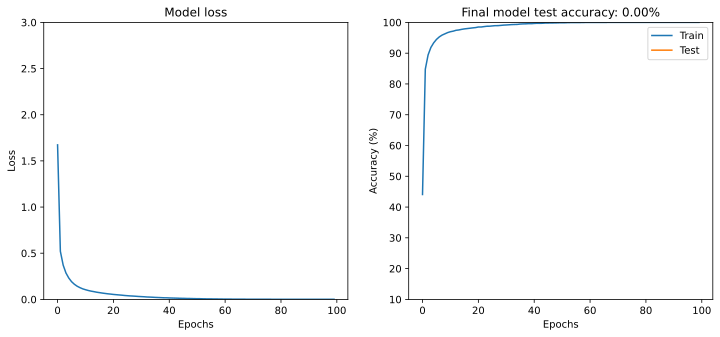

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f"Final model test accuracy: {test_acc[-1]:.2f}%")
ax[1].legend()

plt.show()

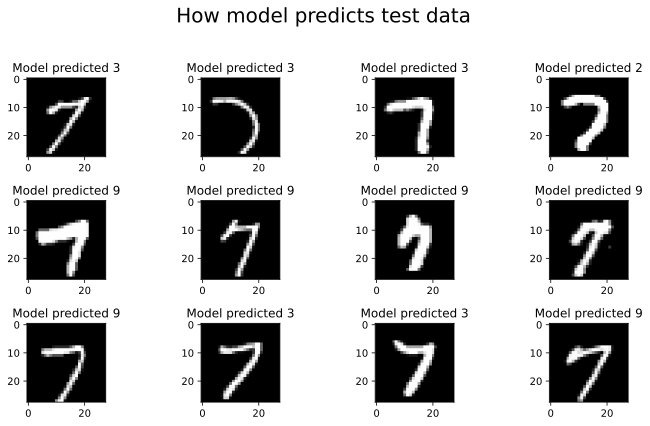

In [11]:
fig, ax = plt.subplots(3,4,figsize=(10,6))

for ax in ax.flatten():
    randimg2show = np.random.randint(0, high=test_loader.dataset.tensors[0].shape[0])
    
    img = np.reshape(test_loader.dataset.tensors[0][randimg2show, :], (28, 28))
    predict = torch.argmax(model(test_loader.dataset.tensors[0][randimg2show, :]))
    
    ax.set_title(f"Model predicted {predict}")
    ax.imshow(img, cmap='gray')
    
plt.suptitle("How model predicts test data", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

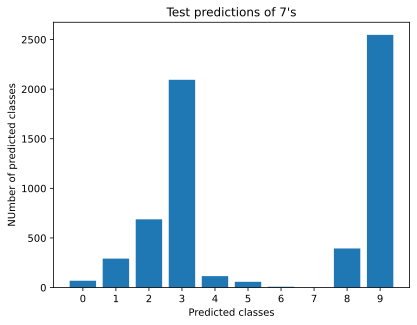

In [12]:
test_predicts = torch.argmax(model(test_data_tensor).detach(), axis=1).detach()
unique_predicts, count_predicts = torch.unique(test_predicts, return_counts=True)

plt.bar(unique_predicts, count_predicts)
plt.xlabel('Predicted classes')
plt.ylabel('NUmber of predicted classes')
plt.title("Test predictions of 7's")
# plt.yscale('log')
plt.xticks(np.arange(10))

plt.show()